<a href="https://colab.research.google.com/github/afraz-rupak/ImageClassificationUsingTransferLearning/blob/main/LabTask_Afraz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path='/content/drive/MyDrive/Colab Notebooks/Mini Dataset'

In [4]:
print(os.listdir(file_path))
classes = os.listdir(file_path + "/Mini Dataset")
print(classes)

['Mini Dataset']
['East Asian', 'Southeast Asian', 'Indian']


In [5]:
EastAsian_files = os.listdir(file_path + "/Mini Dataset/East Asian")
print('No. of training examples for East Asian people image:', len(EastAsian_files))
print(EastAsian_files[:5])

No. of training examples for East Asian people image: 1000
['1.jpg', '1011.jpg', '1009.jpg', '100.jpg', '1015.jpg']


In [6]:
Indian_files = os.listdir(file_path + "/Mini Dataset/Indian")
print('No. of training examples for Indian people image:', len(Indian_files))
print(Indian_files[:5])

No. of training examples for Indian people image: 1000
['1008.jpg', '101.jpg', '1010.jpg', '1022.jpg', '103.jpg']


In [7]:
SoutheastAsian_files = os.listdir(file_path + "/Mini Dataset/Southeast Asian")
print('No. of training examples for Southeast Asian people image:', len(SoutheastAsian_files))
print(SoutheastAsian_files[:5])

No. of training examples for Southeast Asian people image: 1000
['6722.jpg', '6562.jpg', '6858.jpg', '6766.jpg', '6719.jpg']


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
dataset = ImageFolder(file_path+'/Mini Dataset', transform=ToTensor())

In [10]:
len(dataset)

3000

In [11]:
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2500, 500)

In [12]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(224, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [13]:
batch_size=32

In [14]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape: torch.Size([32, 3, 224, 224])


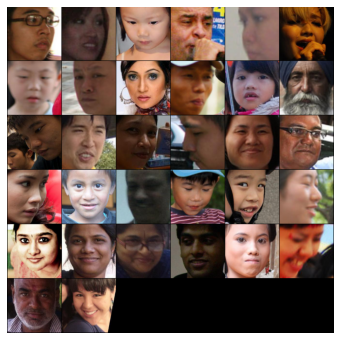

In [15]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=6).permute((1, 2, 0)))
    break

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [19]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [20]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_loader:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([32, 3, 224, 224])


In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 16)
        self.conv2 = conv_block(16, 32, pool=True)
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        
        self.conv3 = conv_block(32, 64, pool=True)
        self.conv4 = conv_block(64, 128, pool=True)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(6272, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.3466045558452606, 'val_loss': 1.0990289449691772}]

In [26]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 1.7555, val_loss: 1.1864, val_acc: 0.4337
Epoch [1], last_lr: 0.00081, train_loss: 1.2615, val_loss: 1.1368, val_acc: 0.4355
Epoch [2], last_lr: 0.00131, train_loss: 1.2147, val_loss: 2.0979, val_acc: 0.3903
Epoch [3], last_lr: 0.00198, train_loss: 1.5230, val_loss: 1.6931, val_acc: 0.3362
Epoch [4], last_lr: 0.00279, train_loss: 1.3159, val_loss: 2.2810, val_acc: 0.3441
Epoch [5], last_lr: 0.00371, train_loss: 1.3718, val_loss: 1.1521, val_acc: 0.4483
Epoch [6], last_lr: 0.00469, train_loss: 1.2581, val_loss: 1.1186, val_acc: 0.4986
Epoch [7], last_lr: 0.00570, train_loss: 1.1714, val_loss: 1.0100, val_acc: 0.5054
Epoch [8], last_lr: 0.00668, train_loss: 1.0369, val_loss: 1.0287, val_acc: 0.4826
Epoch [9], last_lr: 0.00760, train_loss: 0.9987, val_loss: 1.1134, val_acc: 0.4438
Epoch [10], last_lr: 0.00841, train_loss: 0.9862, val_loss: 1.0399, val_acc: 0.4827
Epoch [11], last_lr: 0.00908, train_loss: 1.0586, val_loss: 1.0575, val_acc: 0.4536
Ep

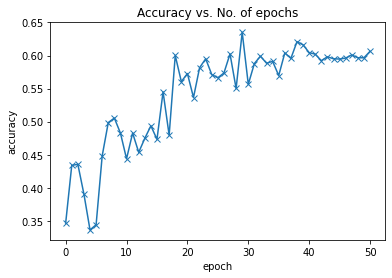

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

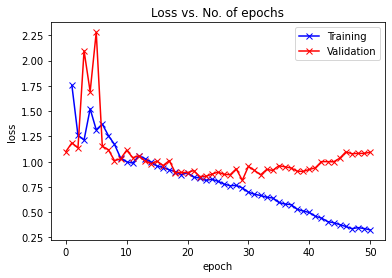

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

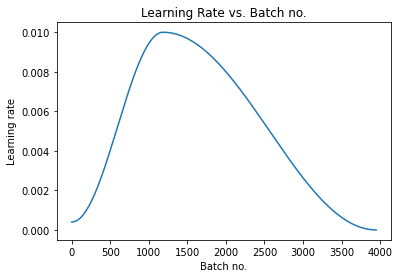

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)